# Data Mining - MiniLab
### Iram Bakhtiar, Steven Cocke, Rebecca Holsapple

------

## Table of Contents
1. [Create Models](#CreateModels)
2. [Model Advantages](#ModelAdvantages)
3. [Interpret Feature Importance](#InterpretFeatureImportance)
4. [Interpret Support Vectors](#InterpretSupportVectors)



### 1. Create Models


#### Section Objective:
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

We have decided to use the Bank Marketing dataset available on Kaggle [https://www.kaggle.com/henriqueyamahata/bank-marketing]. It is prior marketing campaign data of a Portuguese bank. The bank made use of phone calls to clients to get them to subscribe to term bank deposits. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

Before we create the models, it will be beneficial to provide a dictionary so that the variables in the analysis are easily understaood. The disctionary is being sourced from Kaggle's web page for the data

## Dictionary  
### Bank client data:
**Age** (numeric)  
**Job** : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')  
**Marital** : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)  
**Education** (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')  
**Default**: has credit in default? (categorical: 'no', 'yes', 'unknown')  
**Housing**: has housing loan? (categorical: 'no', 'yes', 'unknown')  
**Loan**: has personal loan? (categorical: 'no', 'yes', 'unknown')  

### Related with the last contact of the current campaign:
**Contact**: contact communication type (categorical: 'cellular','telephone')  
**Month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
**Day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
**Duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  

### Other attributes:
**Campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
**Pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
**Previous**: number of contacts performed before this campaign and for this client (numeric)  
**Poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  

### Social and economic context attributes
**Emp.var.rate**: employment variation rate - quarterly indicator (numeric)  
**Cons.price.idx**: consumer price index - monthly indicator (numeric)    
**Cons.conf.idx**: consumer confidence index - monthly indicator (numeric)  
**Euribor3m**: euribor 3 month rate - daily indicator (numeric)  
**Nr.employed**: number of employees - quarterly indicator (numeric)  

### Output variable (desired target):
**y** - has the client subscribed a term deposit? (binary: 'yes', 'no')  

In [2]:
import pandas as pd
import numpy as np
import math
import re
import statistics
#import UtilityFunctions2
#import UtilityFunctions3
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from IPython.display import display, HTML
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
import warnings
import matplotlib.pyplot as plt
#import plotly.tools as tls

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

%matplotlib inline


#retrieve dataset
df = pd.read_csv("bank-additional-full.csv", delimiter=";")

#preview dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
import sys
!{sys.executable} -m pip install plotly

In [4]:
import plotly.tools as tls

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

It can be seen that the dataset has no missing values. We have 10 features that are objects. We would also like to see if the data is imbalanced with regards to the response variable 'y'.

no: 36548
yes: 4640
Proportion: 7.88 : 1


<Figure size 576x360 with 0 Axes>

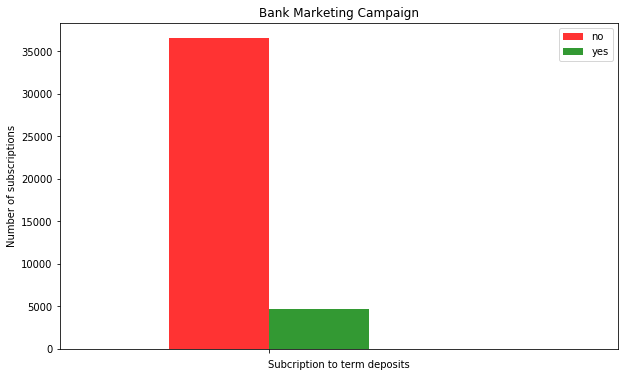

In [6]:

plt.figure(figsize=(8,5))
target_count = df.y.value_counts()
print('no:', target_count[0])
print('yes:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')



# For plotting
n_groups = 1
no=df.y.value_counts()[0]
yes=df.y.value_counts()[1]
 

index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, no, bar_width,
                 alpha=opacity,
                 color='r',
                 label='no')
 
plt.bar(index + bar_width, yes, bar_width,
                 alpha=opacity,
                 color='g',
                 label='yes')
 
plt.xlabel('Subcription to term deposits')
plt.ylabel('Number of subscriptions')
plt.title('Bank Marketing Campaign')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

Out of a total of 41,188 records only 4,640 records are for subscriptions bought as a result of the marketing campaign. That is 7 times less than subscription not bought as a result of the marketing campaign. We have imbalanced data. This also means that accuracy will not give a realiable read of the performance of the models. Two  ways of treating imbalanced data is to use downsampling or upsampling. Even though downsample would create an even dataset, we are at risk of deleting useful data, since it would delete "no" responses and save the "yes" responses. And with 41K records, we don't have a very large data set and it may adversely affect us.


We will split the data. But before we do that we will change the categorical variables into continuous

In [7]:

# changing to continuous variables

from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
df['job']      = labelencoder_X.fit_transform(df['job']) 
df['marital']  = labelencoder_X.fit_transform(df['marital']) 
df['education']= labelencoder_X.fit_transform(df['education']) 
df['default']  = labelencoder_X.fit_transform(df['default']) 
df['housing']  = labelencoder_X.fit_transform(df['housing']) 
df['loan']     = labelencoder_X.fit_transform(df['loan']) 

# creating buckets of ages
def age(dataframe):
    dataframe.loc[dataframe['age'] <= 32, 'age'] = 1
    dataframe.loc[(dataframe['age'] > 32) & (dataframe['age'] <= 47), 'age'] = 2
    dataframe.loc[(dataframe['age'] > 47) & (dataframe['age'] <= 70), 'age'] = 3
    dataframe.loc[(dataframe['age'] > 70) & (dataframe['age'] <= 98), 'age'] = 4
           
    return dataframe

age(df);

# Label encoder order is alphabetical
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
df['contact']     = labelencoder_X.fit_transform(df['contact']) 
df['month']       = labelencoder_X.fit_transform(df['month']) 
df['day_of_week'] = labelencoder_X.fit_transform(df['day_of_week'])

df['poutcome']     = labelencoder_X.fit_transform(df['poutcome']) 

#Multiply cons.conf.idx by -1 to make it positive for regression
df['cons.conf.idx'] = -1*df['cons.conf.idx']



In [8]:
df.y[df.y == 'yes'] = 1
df.y[df.y == 'no'] = 0
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,3,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,36.4,4.857,5191.0,0
1,3,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,36.4,4.857,5191.0,0
2,2,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,36.4,4.857,5191.0,0
3,2,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,36.4,4.857,5191.0,0
4,3,7,1,3,0,0,2,1,6,1,...,1,999,0,1,1.1,93.994,36.4,4.857,5191.0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null int64
marital           41188 non-null int64
education         41188 non-null int64
default           41188 non-null int64
housing           41188 non-null int64
loan              41188 non-null int64
contact           41188 non-null int64
month             41188 non-null int64
day_of_week       41188 non-null int64
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null int64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(15), object(1)
memory usage: 6.6+ M

In [10]:
df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
23312,3,5,1,0,1,2,0,0,1,4,...,4,999,0,1,1.4,93.444,36.1,4.964,5228.1,0
24140,3,9,1,7,0,0,0,0,7,1,...,1,999,1,0,-0.1,93.200,42.0,4.191,5195.8,0
30211,1,0,2,3,0,2,0,0,0,2,...,1,999,0,1,-1.8,93.075,47.1,1.365,5099.1,0
13707,3,9,0,5,0,2,0,1,3,2,...,1,999,0,1,1.4,93.918,42.7,4.963,5228.1,0
13710,1,0,1,3,0,0,0,0,3,2,...,1,999,0,1,1.4,93.918,42.7,4.963,5228.1,1
26456,2,4,2,6,0,2,2,0,7,2,...,1,999,0,1,-0.1,93.200,42.0,4.076,5195.8,0
26028,2,0,0,2,0,1,1,0,7,4,...,2,999,0,1,-0.1,93.200,42.0,4.120,5195.8,0
23112,1,0,1,6,0,2,2,0,1,3,...,12,999,0,1,1.4,93.444,36.1,4.965,5228.1,0
22516,3,0,0,6,0,2,0,0,1,0,...,1,999,0,1,1.4,93.444,36.1,4.964,5228.1,0
8942,3,0,1,0,0,0,0,1,4,2,...,4,999,0,1,1.4,94.465,41.8,4.866,5228.1,0


In [11]:
# Import resample package
from sklearn.utils import resample

# Upsampling
df_majority = df[df.y ==0]
df_minority = df[df.y ==1]
 
# Upsampling minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples= int(4640*7.88),     # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.y.value_counts()

# Or we can upsample as shown below while splitting data

1    36563
0    36548
Name: y, dtype: int64

In [12]:
#Split
from sklearn.model_selection import train_test_split


In [13]:
data = df.drop(['nr.employed','emp.var.rate'],axis=1)
    
data.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m
count,41188.000000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,1.978610,3.72458,1.172769,3.747184,0.208872,1.071720,0.327425,0.365252,4.230868,2.004613,258.285010,2.567593,962.475454,0.172963,0.930101,93.575664,40.502600,3.621291
std,0.735758,3.59456,0.608902,2.136482,0.406686,0.985314,0.723616,0.481507,2.320025,1.397575,259.279249,2.770014,186.910907,0.494901,0.362886,0.578840,4.628198,1.734447
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,92.201000,26.900000,0.634000
25%,1.000000,0.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,102.000000,1.000000,999.000000,0.000000,1.000000,93.075000,36.400000,1.344000
50%,2.000000,2.00000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,2.000000,180.000000,2.000000,999.000000,0.000000,1.000000,93.749000,41.800000,4.857000
75%,2.000000,7.00000,2.000000,6.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,319.000000,3.000000,999.000000,0.000000,1.000000,93.994000,42.700000,4.961000
max,4.000000,11.00000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,4918.000000,56.000000,999.000000,7.000000,2.000000,94.767000,50.800000,5.045000


Due to long computational times, a sample of 5000 is used before splitting the data into test/train.

In [14]:
#response y

nf = data.sample(5000)
y = nf.y
y=y.astype('int')

#drop y, also drop duration as it is not suitable for prediction
X = nf.drop(["y","duration"], axis=1)


#split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
X_true, y_true = X_train[y_train == 1], y_train[y_train == 1]
X_resampled, y_resampled = resample(X_train[y_train == 0], y_train[y_train == 0], n_samples=(20000), random_state=42)

#Add the additional Upsamples to the training data
X_train = pd.concat([X_resampled, X_true])
y_train = pd.concat([y_resampled, y_true])

In [16]:
%%time

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'cv': [2,4,10],
    "class_weight": [{1:.5},{1:1},{1:1.5}]
}]

log_reg = LogisticRegressionCV(n_jobs=-1)#

grid_search = GridSearchCV(log_reg, param_grid, scoring="neg_mean_squared_error")

grid_search.fit(X_train, y_train)

log_reg = grid_search.best_estimator_

print(log_reg)

LogisticRegressionCV(Cs=10, class_weight={1: 1.5}, cv=2, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)
CPU times: user 19.6 s, sys: 338 ms, total: 20 s
Wall time: 41.3 s


In [17]:
# 10 k-fold internal cross validation separation for training
k_fold = KFold(n_splits=10,shuffle=True)

# create pipeline
pipe = Pipeline([('reduce_dim', NMF()),
                  ('scale', StandardScaler()), 
                  ('clf', LogisticRegression())])

In [18]:
#Number of features we will be selecting for feature selection
N_FEATURES_OPTIONS = [4,8,12,16]
#Alpha and C we will be using for our classifiers
C_OPTIONS = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

# options for running models
grid_options = [
    {
        'reduce_dim': [None],
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
]

# run grid_options with the pipline
grid_search = GridSearchCV(pipe, param_grid=grid_options, cv=k_fold, n_jobs=-1, verbose=1)

# train the model
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 48.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 49.3min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=None, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, cla...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'reduce_dim': [None], 'scale': [None, StandardScaler(copy=True, with_mean=True, with_std=True)], 'clf': [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_st...ose=0, warm_start=False)], 'clf__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 10

In [19]:
# optionally load saved model from previous learning to save time
from sklearn.externals import joblib
#grid_search = joblib.load('saved_model.pkl')

# Loads all parameters run into a dictionary 
params = np.array(grid_search.cv_results_['params'])

# Loads all mean test scores into an array
mean_scores = np.array(grid_search.cv_results_['mean_test_score'])

,4,8,12,16,None
NMF,0.100000,0.132143,0.164286,0.196429,0.983266
PCA,0.110714,0.142857,0.175000,0.207143,0.983266
SelectKBest,0.981455,0.981602,0.982874,0.983706,0.983266


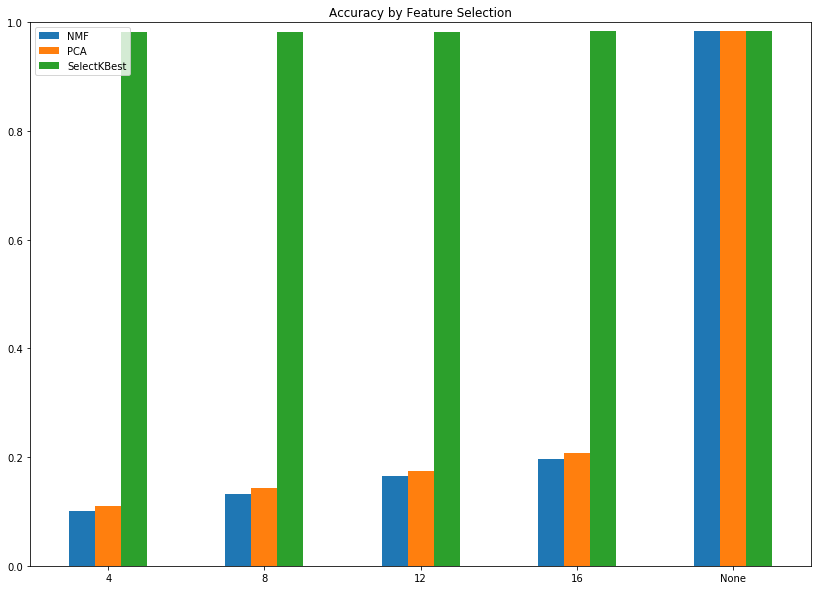

In [20]:
# reduction models
reduce_labels=['NMF','PCA','SelectKBest']

# translate N Features array to string array
temp_N_FEATURES_OPTIONS = [str(r) for r in N_FEATURES_OPTIONS]
temp_N_FEATURES_OPTIONS=temp_N_FEATURES_OPTIONS+['None']

# empty dataframe to fill with 
# mean test accuracy by N Features variable and different feature reduction models

reduce_temp = pd.DataFrame(
    columns=reduce_labels, index=temp_N_FEATURES_OPTIONS, 
    data=np.linspace(.1,.25,num=len(temp_N_FEATURES_OPTIONS)*len(reduce_labels)).reshape(+len(temp_N_FEATURES_OPTIONS),
                                                                                           len(reduce_labels)))

# initialize N_FEAT
N_FEAT = ""

for i, (param, score) in enumerate(zip(params, mean_scores)):
    trigger=0
    reduce_state = str(param['reduce_dim']).split('(')[0]
    if 'reduce_dim__k' in param:
        N_FEAT = str(param['reduce_dim__k'])
        trigger=1
    elif 'reduce_dim__n_components' in param:
        N_FEAT = str(param['reduce_dim__n_components'])
        trigger=1
    else:
        if reduce_temp.at['None','NMF'] < score:
            for method in reduce_labels:
               reduce_temp.at['None',method] = score
    if trigger == 1:
        if reduce_temp.at[N_FEAT,reduce_state] < score:
            reduce_temp.at[N_FEAT,reduce_state] = score
            
# print a grid with the best accuracies
display(reduce_temp.transpose())

# print a bar plot with best accuracies
reduce_temp.plot(kind='bar',ylim=(0,1),figsize=(14,10),title='Accuracy by Feature Selection',rot=0);    

In [21]:
print('The Index of the best model is',grid_search.best_index_)
print('The parameters of the best model is')
display(grid_search.best_params_)
print('The accuracy of the best model is',round(grid_search.best_score_*100,4))

The Index of the best model is 99
The parameters of the best model is


{'clf': SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 'clf__C': 1000.0,
 'reduce_dim': SelectKBest(k=16, score_func=<function chi2 at 0x1a22f1ae18>),
 'reduce_dim__k': 16,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

The accuracy of the best model is 98.3706


### 2. Model Advantages


#### Section Objective:
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

In [22]:
best_score=0
idx = 0

# find index of the best model based on LogisticRegression
for index, (param, score) in enumerate(zip(params, mean_scores)):
    # split first part of clf dictionary for the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'LogisticRegression' and score>best_score:
        best_score=score
        idx=index

# set parameters to best found with the index
pipe.set_params(**grid_search.cv_results_['params'][idx])
print('Time to run Logistic Regression model:')
%time pipe.fit(X_train,y_train)

# predict
y_pred = pipe.predict(X_test)

# accuracy of external cross validation 
accuracy = accuracy_score(y_test,y_pred)
print ('Accuracy of Logistc Regression:',accuracy)

# find index of the best model based on LogisticRegression

best_score=0
idx = 0

# find index of the best model based on SVC

for index, (param, score) in enumerate(zip(params, mean_scores)):
    # split first part of clf dictionary for the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'SVC' and score>best_score:
        best_score=score
        idx=index

# set parameters to best found with the index
pipe.set_params(**grid_search.cv_results_['params'][idx])
print('Time to run SVC model:')
%time pipe.fit(X_train,y_train)

# predict
y_pred = pipe.predict(X_test)

# accuracy of external cross validation 
accuracy = accuracy_score(y_test,y_pred)
print ('Accuracy of SVC:',accuracy)

Time to run Logistic Regression model:
CPU times: user 349 ms, sys: 10.4 ms, total: 359 ms
Wall time: 93.8 ms
Accuracy of Logistc Regression: 0.91
Time to run SVC model:
CPU times: user 11.4 s, sys: 164 ms, total: 11.6 s
Wall time: 11 s
Accuracy of SVC: 0.842


,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0
SVC,0.978617,0.978617,0.978617,0.978617,0.980526,0.982923,0.983266,0.983706,0.983315
LogisticRegression,0.978617,0.978617,0.978617,0.978715,0.978764,0.978764,0.978764,0.978764,0.978764
SGDClassifier,0.111538,0.128846,0.146154,0.163462,0.180769,0.198077,0.215385,0.232692,0.250000


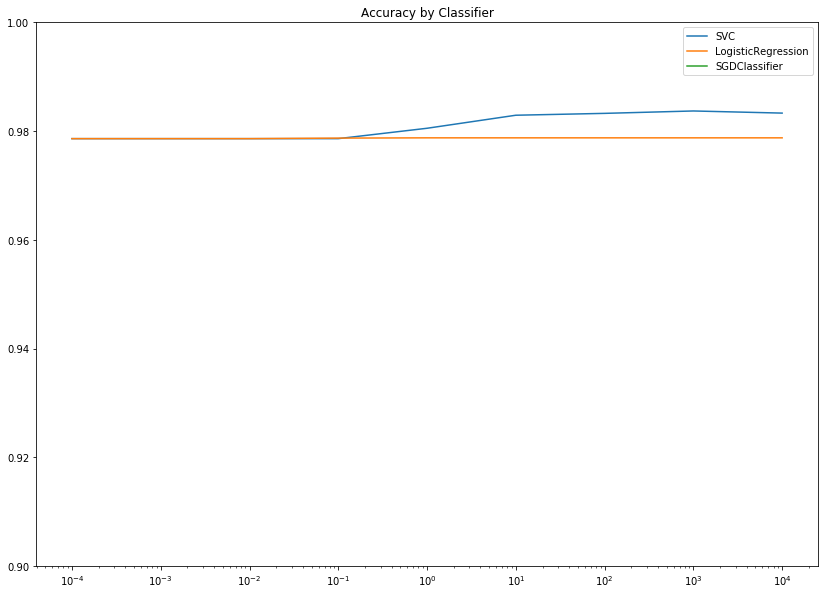

In [23]:
#classifier_labels=['SVC','LogisticRegression','SGDClassifier']
classifier_labels=['SVC','LogisticRegression','SGDClassifier']

# Creates an empty dataframe and fill with mean test accuracy 
# by C global variable and the different classifiers

classifier_temp = pd.DataFrame(columns=classifier_labels,index=C_OPTIONS,
                               data=np.linspace(.1,.25,num=len(C_OPTIONS)*len(classifier_labels)).reshape(len(C_OPTIONS),len(classifier_labels)))
classifier_temp.fillna(0,inplace=True)

for i, (param, score) in enumerate(zip(params, mean_scores)):
    C = param['clf__C'] if 'clf__C' in param else param['clf__alpha']
    class_state = str(param['clf']).split('(')[0]
    if classifier_temp.at[C,class_state] < score:
        classifier_temp.at[C,class_state] = score

# print grid of best accuracies
        
display(classifier_temp.transpose())   

# line plot with best accuracies
classifier_temp.plot(logx=True,ylim=(0.9,1),figsize=(14,10),title='Accuracy by Classifier');

We can evaluate the effectiveness of the models by looking at the accuracy of the two models.

From below, we have the results as:

Time to run Logistic Regression model: 

Wall time: 93.8 ms 

Accuracy: .91

Time to run SVC model: 

Wall time: 11 s 

Accuracy: .842

The Logistic model shows better accuracy of the models, 91%, by almost 10%. SVC had an accuracy of 84% shown above. The model is fitted using the best parameters found during data training for Logistic Regression and SVC. The Logistic Regression fits the model faster than the SVC model. However, when needing to train large amounts of data, this slightly faster performance will scale up to saving time with only a slightly reduced accuracy.

Logistic Regression can be prone to overfitting with a large number of features. This can be controlled by adding a regularization parameter ('C' parameter) and the accuracy does not change significantly. By choosing the right number of features, we have a better chance of not overfitting using a logistic regression model. This model will be affected by any potential outliers in the data. Outliers have no effect with SVC since it builds points close to the hyperplane boundary lines. The logistic regression model is less sensitive to changing the regularization parameter.

### 3. Interpret Feature Importance


#### Section Objective:
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

best model is index:  29
The accuracy of the best Logistic Regression is 91.0


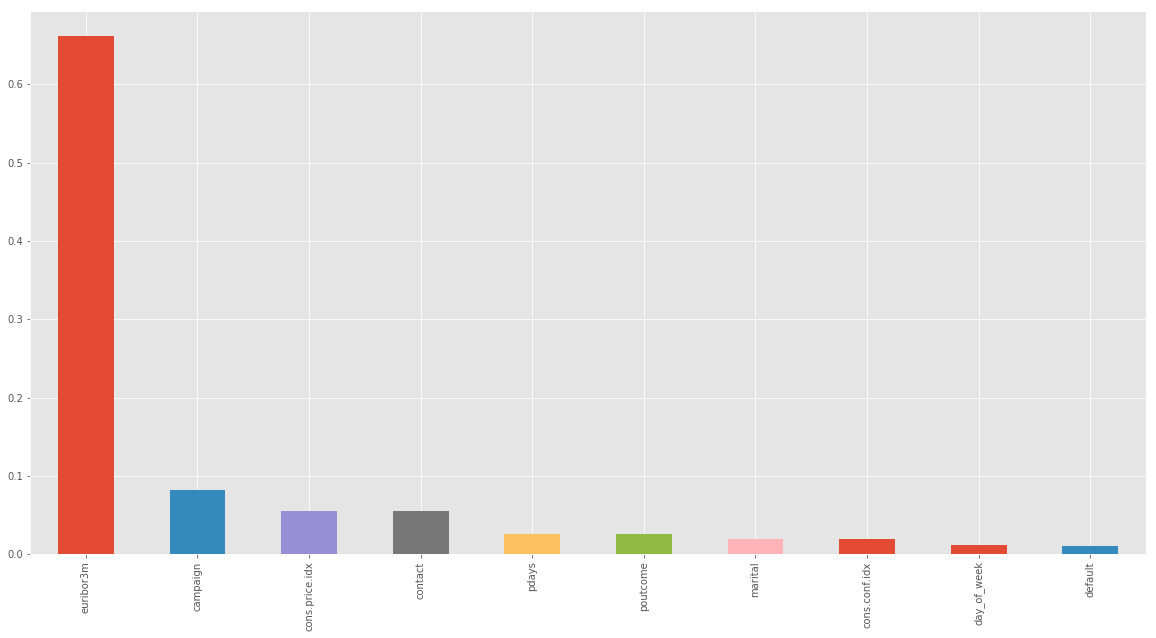

The top 10 features that influence purchasing are the following


euribor3m         0.661066
campaign          0.081649
cons.price.idx    0.055168
contact           0.054967
pdays             0.026365
poutcome          0.026330
marital           0.019523
cons.conf.idx     0.019134
day_of_week       0.012106
default           0.010387
dtype: float64

In [24]:
best_score=0
idx = 0

# get index of the best model based on LogisticRegression
for index, (param, score) in enumerate(zip(params, mean_scores)):
    # split first part of clf dictionary for the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'LogisticRegression' and score>best_score:
        best_score=score
        idx=index

# set parameters to best found with the index
print('best model is index: ', idx)

pipe.set_params(**grid_search.cv_results_['params'][idx])
pipe.fit(X_train,y_train)

# get predicted coefficients 
coef = pipe.steps[2][1].coef_

# boolean vector mask based on Kbest selection
#print (pipe.steps[0])
#mask = pipe.steps[0][1].get_support()
#new_features= []

# feature names from the columns of the original dataset
new_features = list(X.columns.values)

#for bool, feature in zip(mask, feature_names):
    #if bool:
        #new_features.append(feature)

# dataframe with coefficients and features
predicted_data = pd.DataFrame(coef, columns=new_features)

# predict
y_pred = pipe.predict(X_test)

# accuracy of external cross validation 
accuracy = accuracy_score(y_test,y_pred)

print('The accuracy of the best Logistic Regression is',round(accuracy*100,4))
        
# sum of squares for columns get influential predictors
sos = predicted_data.apply(lambda row: (row**2).sum(),axis=0)

# display bar plot for features
plt.style.use('ggplot')
plt.figure(figsize = (20,10))
order = pd.Series(pd.Series(sos))
order = order.sort_values(ascending=False)[:10]
order.plot(kind='bar')
plt.show()

print("The top 10 features that influence purchasing are the following")
display(sos.sort_values(ascending=False)[0:10])

The euribor3m is the most influential attribute by far, followed by the campaign, cons.price.idx, and contact attributes. After this, there is a drop off. This can be interpreted as euribor3m being a highly predictive attribute of the target.

### 4. Interpret Support Vectors

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

We sampled the data previously (5000 records) and trained the dataset on both Logistic and SVM. Below is the accuracy for the best SVM model. 

In [25]:
# search for best SVM model 
best_score=0
best_index = 0

# find index of the best SVM model
for index, (param, score) in enumerate(zip(params, mean_scores)):
    # clf dictionary first part has the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'SVC' and score>best_score:
        best_score=score
        best_index=index

# set parameters for the best model from the best_index
pipe.set_params(**grid_search.cv_results_['params'][best_index])
pipe.fit(X_train,y_train)

# Predict y
y_pred = pipe.predict(X_test)

# get accuracy for the external cross validation 
accuracy = accuracy_score(y_test,y_pred)
print('The accuracy of the best SVM is',round(accuracy*100,3))

# set parameters to best found with the index
print('best model is index: ', best_index)



The accuracy of the best SVM is 84.2
best model is index:  99


In [26]:
grid_search.cv_results_['params'][best_index]

{'clf': SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 'clf__C': 1000.0,
 'reduce_dim': SelectKBest(k=16, score_func=<function chi2 at 0x1a22f1ae18>),
 'reduce_dim__k': 16,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

For the Support Vectors, it can be difficult to interpret the SVM weights, however for the linear SVM there actually is a useful interpretation:
In a linear SVM, the result is a hyperplane that separates the classes as best as possible. The weights represent this hyperplane, by giving you the coordinates of a vector which is orthogonal to the hyperplane - these are the coefficients given by svm.coef_.
The direction of this vector gives us the predicted class, so if you take the dot product of any point with the vector, you can tell on which side it is: if the dot product is positive, it belongs to the positive class, if it is negative it belongs to the negative class.
We can learn something about the importance of each feature. The SVM vector's size of the coefficient relative to the other ones gives an indication of how important the feature was for the separation. For example if only the first coordinate is used for separation, w will be of the form (x,0) where x is some non zero number and then |x|>0.